In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython
import numpy as np
import pandas as pd


In [2]:
ds = pd.read_csv('dataset\labels_dataset1.csv')
ds.head()

,path,start,duration,end,label
0,012213d40662f86e8f775379bbf94dec,61.186,2.5,63.686,whistle
1,0159af9f3ca04ada46f0c353ac210bb8,76.260,17.0,93.260,cetaceans_allfreq
2,035195366b6849c1b339cff8e6de574a,10.438,0.3,10.738,whistle
3,035195366b6849c1b339cff8e6de574a,22.438,0.3,22.738,whistle
4,035195366b6849c1b339cff8e6de574a,24.438,2.9,27.338,whistle


### Data-Audio engineering

In [96]:
ds.shape

(71101, 5)

In [3]:
ds.drop(ds.loc[(ds['duration'] > 1.3) & (ds['label'] == 'click')].index, inplace=True)
# ds.drop((ds['label'] == 'click').index, inplace=True)
ds.shape

(3487, 5)

In [93]:
ds['path'].value_counts()

9d2bc9882d41454145c10db5d9805712    22162
58d4dcc33ba2fe4d9d3ab55261fa25ab    17739
f305fe3922cd78d5a126e2def43532d9     4304
8128687fe56c859148540bb7500b2548     3983
c3319d870881e40a4da1999a21b61674     3750
                                    ...  
6a7b5a0932b48df463177327f29150b3        1
67ca59ba0cffe40ff7c254f2ce8f128f        1
67516106168dbcb8129677bf9b538163        1
6402776831efb68288d4980b4c895ea8        1
829d7a60bcb283c1fd0bde3c765bd5f5        1
Name: path, Length: 437, dtype: int64

In [94]:
# localice all rows of specific path
# x = labels[labels['path'] == '9d2bc9882d41454145c10db5d9805712']
# x = labels[labels['path'] == '9d2bc9882d41454145c10db5d9805712']
# x = labels[labels['path'] == '67ca59ba0cffe40ff7c254f2ce8f128f']
x = ds[ds['path'] == '58d4dcc33ba2fe4d9d3ab55261fa25ab']

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

path = './dataset/dataset1_all_wav/datathon2022/dataset1/'
file_sample = path + '9d2bc9882d41454145c10db5d9805712' + '.wav'
y, sr = librosa.load(file_sample, sr=None)

In [48]:
sr

50000

In [23]:
n_fft = 2**11 # Nro. de muestras para cada ventana donde se va a realizar la stft
hop_length = int(n_fft/4) # Cuantas muestras se va a mover la ventana en cada desplazamiento (hop: salto)
stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
spectogram_magnitude = np.abs(stft)
spectogram_phase = np.angle(stft)

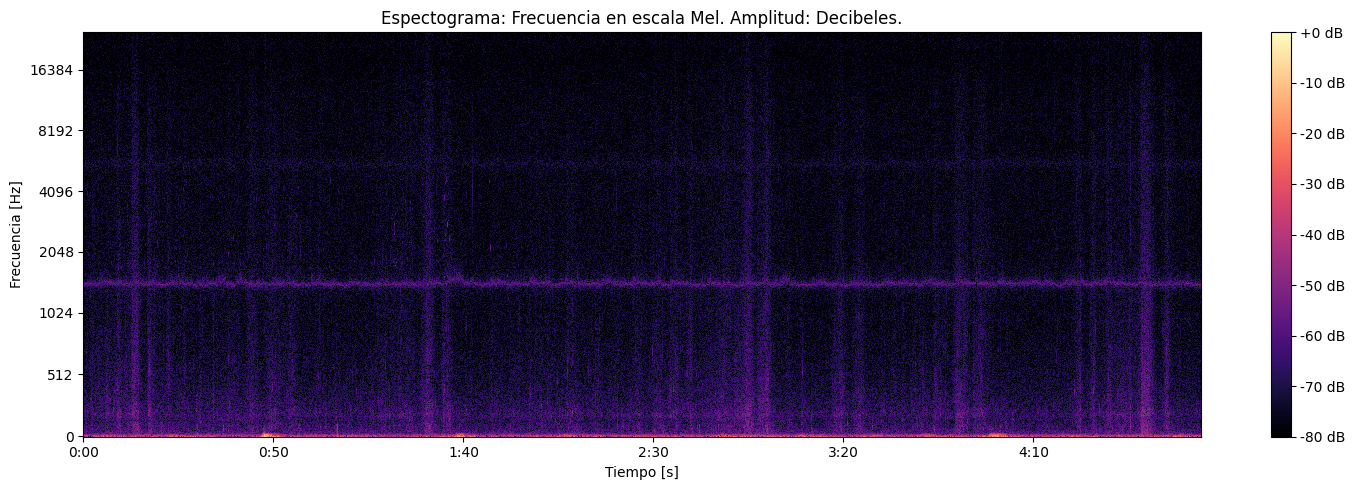

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
fig.patch.set_facecolor('white')

spectogram_dB = librosa.amplitude_to_db(spectogram_magnitude, ref=np.max)
librosa.display.specshow(spectogram_dB, y_axis='mel', fmin=0, x_axis='time', sr=sr, hop_length=hop_length)

# MFFCs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
# librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)

ax.set_title('Espectograma: Frecuencia en escala Mel. Amplitud: Decibeles.')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Frecuencia [Hz]')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# band-pass filter

In [12]:
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.fft import fft

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [19]:
# X_filt = butter_bandpass_filter(y, 1000, 9000, sr, order=9)
a_filt = butter_bandpass_filter(y, 1000, 7000, sr, order=9)
b_filt = butter_bandpass_filter(y, 9000, 20000, sr, order=9)
# Combinar ambos espectrs de frecuencia.
X_filt = a_filt + b_filt

X_filt.shape

(14700000,)

In [22]:
# Crop frequency band 1000-20000 Hz using FFT
X_fft = fft(y)
X_fft = X_fft[0:int(len(X_fft)/2)]
X_fft = X_fft[1000:20000]
X_fft.shape


(19000,)

In [20]:
# X_filt_u = abs(fft(X_filt))[:int(y.shape[0]/2)]

Xstft_filt = librosa.stft(X_filt)
Xstft_db_filt = librosa.amplitude_to_db(abs(Xstft_filt))

In [ ]:
img = librosa.display.specshow(Xstft_db_filt, sr=sr, x_axis='time', y_axis='linear')

In [66]:
import IPython.display as ipd

In [ ]:
# play_annotation_from_df(ipd.Audio(X_filt, rate=sr))
# ipd.Audio(X_filt, rate=sr)

In [ ]:
# butter bandpass for specific frequency from 600 to 20000.
# X_filt = butter_bandpass_filter(y, 600, 20000, sr, order=9)

# remove bandpass between frequency 7000 to 9000.
X_filt = butter_bandpass_filter(y, 0, 7000, sr, order=9)
X_filt = butter_bandpass_filter(X_filt, 9000, 20000, sr, order=9)



In [ ]:
# remove specific range frequency from spectogram

# stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann')
# spectogram_magnitude = np.abs(stft)
# spectogram_phase = np.angle(stft)

# spectogram_magnitude[0:100, :] = 0
# spectogram_magnitude[100:200, :] = 0
# spectogram_magnitude[200:300, :] = 0
# spectogram_magnitude[300:400, :] = 0
# spectogram_magnitude[400:500, :] = 0
# spectogram_magnitude[500:600, :] = 0
